In [2]:
# importing packages and modules
import pandas as pd 
import numpy as np
from pathlib import Path
import math
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from scipy.stats import multivariate_normal


In [3]:
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


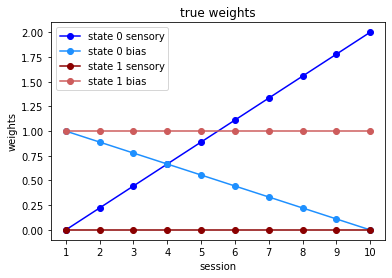

In [4]:
S = 10 # sessions
T = 500 # trials per session
N = T * S
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)
plotting_weights(trueW,sessInd,'true weights')



In [5]:
# Iris' code has reversed columns
def emission_probability(x, w,  z=None, latents=False):
    '''
    Calculating emission probabilities for each session

    Parameters
    ----------
    x: N x D numpy array
    z: N x 1 numpy array
    w: N x K x D x C numpy array

    Returns
    -------
    phi: N x K x C numpy array
        emission probabilities
    '''
    N = x.shape[0]
    D = x.shape[1]
    K = w.shape[1]
    phi = np.empty((N,K,C)) # probability that it is state 1
    for k in range(0,K):
        for c in range(0,C):
            phi[:,k,c] = np.exp(-np.sum(w[:,k,:,c]*x,axis=1))
        phi[:,k,:]  = np.divide((phi[:,k,:]).T,np.sum(phi[:,k,:],axis=1)).T     

    return phi

In [11]:
def simulate_data(trueW, trueP, priorZstart, sessInd, save=False):
    '''
    function that simulates X and Y data from true weights and true transition matrix
    S sessions, K states, D features (in the order: bias, sensory)
    K = 2 BINOMIAL

    Parameters
    ----------
    trueW: S x K x D numpy array
        true weight matrix
    trueP: K X K numpy array
        true probability transition matrix
    priorZstart: int
        prior for initial latent state to be 0
    sessInd: list of int
        indices of each session start, together with last session end
        
    Returns
    -------
    x_sim: N x D
    y_sim: N x C
    z_sim: 

    '''
    # check that weight and transition matrices are valid options

    n = trueW.shape[0] # total timepoints
    k = trueW.shape[1] # states
    d = trueW.shape[2] # features
    c = trueW.shape[3] # classes
    x = np.empty((n,d))
    y = np.zeros((n,c)).astype(int)
    z = np.empty((n,),dtype=int)

    # input data x
    x[:,0] = 1 # bias term
    x[:,1] = stats.uniform.rvs(loc=-16,scale=33,size=n).astype(int)
    # standardizing sensory info
    x[:,1] = x[:,1] - x[:,1].mean()
    x[:,1] = x[:,1] / x[:,1].std()

    # latent variables z 
    for t in range(0,n):
        if (t in sessInd[:-1]): # beginning of session has a new draw for latent
            z[t] = np.random.binomial(n=1,p=1-priorZstart)
        else:
            z[t] = np.random.binomial(n=1, p=trueP[z[t-1],1])
    
    # observation probabilities
    phi = emission_probability(x, trueW,  z=None, latents=False)

    for t in range(0,n):
        y[t,int(np.random.binomial(n=1,p=phi[t,z[t],1]))]=1

    if (save==True):
        np.save('../data/simX', x)
        np.save('../data/simY', y)
        np.save('../data/simZ', z)
    return x, y, z

xSim, ySim, zSim  = simulate_data(trueW=trueW, trueP=trueP, priorZstart=0.5, sessInd=sessInd, save=False)
print(xSim)

[[ 1.         -0.93164315]
 [ 1.          1.37549201]
 [ 1.          0.3867198 ]
 ...
 [ 1.         -0.82177957]
 [ 1.         -0.27246168]
 [ 1.          0.82617412]]


In [12]:
xSim = np.load('../data/simX.npy')
print(xSim)

[[ 1.         -0.93164315]
 [ 1.          1.37549201]
 [ 1.          0.3867198 ]
 ...
 [ 1.         -0.82177957]
 [ 1.         -0.27246168]
 [ 1.          0.82617412]]


In [10]:
phiSim = emission_probability(xSim, trueW,  z=None, latents=False)
print(phiSim[3785,0,:])
print(xSim[-3785,:])
print(trueW[-3785,0,:,:])

[0.11442212 0.88557788]
[1.        0.7308747]
[[0.77777778 0.        ]
 [0.44444444 0.        ]]


In [9]:
# Using Iris' code to fit simulate data and calculate alpha forward and backward

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize, analysis

true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")
# # compute phi for each state from weights 
phi = np.zeros((true_GLMHMM.n,true_GLMHMM.k,true_GLMHMM.c))
for i in range(true_GLMHMM.n):
    for zi in range(true_GLMHMM.k):
        phi[i,zi,:] = true_GLMHMM.glm.observations.compObs(xSim[i,:],trueW[i,zi,:,:])
# print("Observation prob NxKxC")
# print(phi[:,0,:])

# checked forward and backward passes with Iris' function
# ll_s,alpha_s,alpha_prior_s,cs_s = true_GLMHMM.forwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:])
# pBack_s,beta_s,zhatBack_s = true_GLMHMM.backwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:],alpha_s,cs_s)

# inits = 1 # set the number of initializations

# # store values for each initialization
# lls_all = np.zeros((1,250))
# A_all = np.zeros((1,K,K))
# w_all = np.zeros((1,K,D,C))

# fit the model for each initialization
init_p,init_w,_ = true_GLMHMM.generate_params() # initialize the model parameters
#print(init_p)
y0,alpha0,beta0,cs0,A0,phi0,xis0 = true_GLMHMM.fit(reshapeObs(ySim),xSim,init_p,init_w,maxiter=1,sess=sessInd) # fit the model
#print(A_all)



[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


In [10]:
print(init_w[:,:,1])

[[ 0.9  -0.26]
 [-0.58  0.39]]


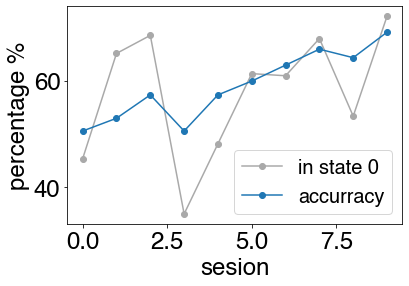

In [11]:
perf,ind = accuracy(xSim,ySim,zSim,s=10)

In [12]:
# already checked with Iris' function that it is correct
def forward_pass(y,P,phi,pi0=None):
    '''
    Calculates alpha scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
        
    Returns
    -------
    ll : float, marginal log-likelihood of the data p(y)
    alpha : nx1 vector of the conditional probabilities p(z_t|x_{1:t},y_{1:t})
    ct : nx1 vector of the forward marginal likelihoods p(y_t | y_1:t-1)
    '''
    T = y.shape[0]
    K = P.shape[0]
    
    alpha = np.zeros((T,K)) # forward probabilities p(z_t | y_1:t)
    alpha_prior = np.zeros((T,K)) # prior probabilities p(z_t | y_1:t-1)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)
    ct = np.zeros(T) # forward marginal likelihoods p(y_t | y_1:t-1)

    # forward pass calculations
    for t in range(0,T):
        lt[t,:] = phi[t,:,y[t]] # likelihood p(y_t | z_t)
        if (t==0): # time point 0
            if (pi0==None):
                alpha_prior[0,:] = np.ones((1,K))/K # prior of z_0 before any data (=uniform)
            else:
                alpha_prior[0,:] = pi0
        else:
            alpha_prior[t,:] = (alpha[t-1,:].T @ P) # conditional p(z_t | y_1:t-1)
        pxz = np.multiply(lt[t],alpha_prior[t,:]) # joint P(y_1:t,z_t)
        ct[t] = np.sum(pxz) # conditional p(y_t | y_1:t-1)
        alpha[t,:] = pxz/ct[t] # conditional p(z_t | y_1:t)
    
    ll = np.sum(np.log(ct)) # marginal log likelihood p(y_1:T) as sum of log conitionals p(y_t | y_1:t-1) 
    
    return alpha,alpha_prior,ct,ll

alpha,alpha_prior,ct,ll = forward_pass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:])



In [13]:
# already checked with Iris' function that it is correct
def backward_pass(y,P,phi,ct,pi0=None):
    '''
    Calculates beta scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
    ct : Tx1 numpy vector of forward marginal likelihoods p(y_t | y_1:t-1), calculated at forward_pass
        
    Returns
    -------
    beta: TxK numpy array 
    
    '''
    T = y.shape[0]
    K = P.shape[0]
    
    beta = np.zeros((T,K)) # backward conditional probabilities p(y_t+1:T | z_t)/p(y_t+1:T | y_1:t)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)

    # last time point
    beta[-1] = 1 # p(z_T=1)

    # backward pass calculations
    for t in np.arange(T-2,-1,-1):
        lt[t+1,:] = phi[t+1,:,y[t+1]] 
        beta[t,:] = P @ (np.multiply(beta[t+1,:],lt[t+1,:]))
        beta[t,:] = beta[t,:] / ct[t+1] # scaling factor
    
    return beta
beta = backward_pass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:],ct)

In [14]:
# checked gammas and zetas against iris'
def posteriorLatents(y, p, phi, alpha, beta, ct):
    ''' 
    calculates marginal posterior of latents gamma(z_t) = p(z_t | y_1:T)
    and joint posterior of successive latens zeta(z_t,z_t+1) = p(z_t,z_t+1 | y_1:T)

    Parameters
    ----------
    y : Tx1 vector of observations with values 0,1,..,C-1
    '''
    N = phi.shape[0]
    K = phi.shape[1]
    C = phi.shape[2]
    T = ct.shape[0]
    gamma = np.empty((T,K)).astype(float) # marginal posterior of latents
    zeta = np.empty((T-1,K,K)).astype(float)

    gamma = np.multiply(alpha,beta) # gamma(z_t) = alpha(z_t) * beta(z_t)
    
    for t in range(0,T-1):#T-1):
        alpha_beta = alpha[t,:].reshape((K,1)) @ beta[t+1,:].reshape((1,K))
        zeta[t,:,:] = np.multiply(alpha_beta,p) 
        zeta[t,:,:] = np.multiply(zeta[t,:,:],phi[t+1,:,y[t+1]]) # change t+1 to t in phi to match Iris'
        zeta[t,:,:] = zeta[t,:,:] / ct[t+1]
    return gamma, zeta
gamma, zeta = posteriorLatents(reshapeObs(ySim[2000:2500,:]), trueP, phiSim[2000:2500,:], alpha, beta, ct)



In [15]:
def weight_negloglike(currentW, x, y, gamma, prevW, nextW, sigma):
    '''
    negative log likelihood function to optimize the weight in M-step
    L(w) = ...

    Parameters
    ----------
    currentW: K x D  vector
        only weights correspind to one current session for C=0
    prevW: K x D x C vector
        weights previous session
    nextW: K x D x C vector
        weights next session
    '''
    T = x.shape[0]
    if(prevW is not None):
        K = prevW.shape[0]
        D = prevW.shape[1]
        C = prevW.shape[2]
    elif(nextW is not None):
        K = nextW.shape[0]
        D = nextW.shape[1]
        C = nextW.shape[2]
    currentW = currentW.reshape((K,D))
    sessW = np.zeros((T,K,D,C))
    for t in range(0,T):
        sessW[t,:,:,0] = currentW[:,:]
    phi = emission_probability(x, sessW,  z=None, latents=False) # N x K x C matrix calculated with currentW
    K = phi.shape[1]
    ll = 0

    for t in range(0,T):
        ll += np.multiply(gamma[t,:],np.log(phi[t,:,y[t]])).sum()
    
    # w | prevW ~ Normal(prevW, sigma^2*Id) and w | nextW ~ Normal(nextW, sigma^2*Id)
    for k in range(0,K):
        if (prevW is not None):
            rv = multivariate_normal(mean=prevW[k,:,0], cov=np.diag(np.square(sigma[k,:])), allow_singular=True)
            ll += np.log(rv.pdf(currentW[k,:]))   
        if (nextW is not None):
            rv = multivariate_normal(mean=nextW[k,:,0], cov=np.diag(np.square(sigma[k,:])), allow_singular=True)
            ll += np.log(rv.pdf(currentW[k,:]))
            
    
    return -ll
weight_negloglike(np.ndarray.flatten(trueW[500,:,:,0]), xSim[0:500], reshapeObs(ySim[0:500]), gamma,trueW[0],trueW[1000], reshapeSigma(0.5,2,2))

296.58410770004286

In [16]:
ourSigma = reshapeSigma(sigma=1,K=K,D=D)
def fit(y, x, initP, initW, sigma, pi0=None, maxIter=250, tol=1e-3, sessInd=None):
    '''
    Fitting function based on EM algorithm

    Parameters
    ----------
    y : NxC vector of observations with values 0 and 1, and exactly one 1 per row
    initP : KxK numpy array
        initial matrix of transition probabilities
    initW: NxKxDxC numpy array
        initial weight matrix
    sigma: KxD matrix
        covariance of weight drifting over sessions

    pi0 : initial kx1 vector of state probabilities for t=1.
    maxiter : int
         The maximum number of iterations of EM to allow. The default is 250.
    tol : float
        The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
    sessions : an optional vector of the first and last indices of different sessions in the data (for separate computations of the E step; first and last entries should be 0 and n, respectively)  
    
    Returns
    -------
    '''
    n = initW.shape[0] # total timepoints
    k = initW.shape[1] # states
    d = initW.shape[2] # features
    c = initW.shape[3] # classes
    sess = len(sessInd)-1
    zeta = np.zeros((n-1,K,K)).astype(float)
    t = int(n/sess)
    y = reshapeObs(y) 

    if sess is None:
        sessInd = [0,n]
        sess = 1 # equivalent to saying the entire data set has one session

    # initialize w and P 
    w = np.copy(initW)
    p = np.copy(initP)

    for iter in range(maxIter):
        print(iter)
         
        # calculate emission probabilities given theta_old
        phi = emission_probability(x, w,  z=None, latents=False)
        # phi[:,:,[0,1]] = phi_original[:,:,[1,0]] # when checking against Iris'

        ll = 0

        # EM step for each session independently 
        for s in range(0,sess):
            
            # E step - calculates all probabilities given theta_old = previous weight and transition matrix p
            alphaSess, _, ctSess, llSess = forward_pass(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:])
            betaSess = backward_pass(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:],ctSess)
            gammaSess, zetaSess = posteriorLatents(y[sessInd[s]:sessInd[s+1]],p,phi[sessInd[s]:sessInd[s+1],:,:], alphaSess, betaSess, ctSess)
            
            # merging info for all sessions 
            zeta[sessInd[s]:sessInd[s+1]-1,:,:] = zetaSess[:,:,:] 
            ll += llSess
            
            # M step for weights - weights are updated for each session individually (as neighboring session weights have to be fixed)
            w_flat = np.ndarray.flatten(w[sessInd[s],:,:,0]) # flatten weights for optimization 
            prevW = w[sessInd[s-1]] if s!=0 else None
            nextW = w[sessInd[s+1]] if s!=sess-1 else None
            optimized = minimize(weight_negloglike, w_flat, args=(x[sessInd[s]:sessInd[s+1]], y[sessInd[s]:sessInd[s+1]], gammaSess,prevW,nextW, sigma))
            optimizedW = np.reshape(optimized.x,(K,D)) # reshape and update weights
            # updating weight w for that session
            w[sessInd[s]:sessInd[s+1],:,:,0] = optimizedW #np.repeat(optimizedW[np.newaxis], sessInd[s+1]-sessInd[s-1], axis=0)
            
        
        #gamma, zeta = posteriorLatents(y, p, phi, alpha, beta, cs) # calculate zeta for whole dataset after merging like Iris'

        # M-step for transition matrix p - for all sessions together
        # Closed form update - correct formula
        for i in range(0,K):
            for j in range(0,K):
                p[i,j] = zeta[:,i,j].sum()/zeta[:,i,:].sum()
    
    return w, p
    #return y,p,phi,zeta
initP = init_p
initW = np.empty((N,K,D,C))
initW[:] = init_w
initW = initW[:,:,:,[1,0]]
w1, p1= fit(ySim,xSim,initP,initW,sigma=ourSigma,maxIter=250,tol=1e-3,sessInd=sessInd)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


123
124
125
126
127
128
129
130
131
132
133
134
135
136


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


137
138


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


242
243
244
245


/Users/lencacuturela/opt/anaconda3/envs/glmhmm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


246
247
248
249


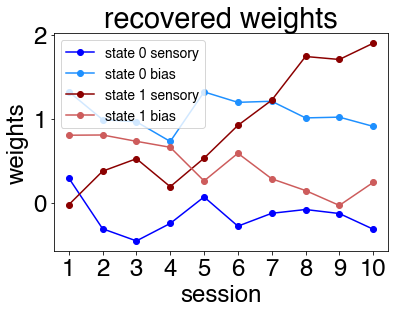

In [22]:
plotting_weights(w1,sessInd,'recovered weights')

In [66]:
print(initW[0,:,:,0])

[[-0.95 -0.71]
 [-0.62  0.17]]


In [17]:
# to check reshape Obs for C>=3